In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import plotly.express as px
import plotly.graph_objects as go
import geopandas as gpd
from shapely.geometry import box
from shapely.geometry import Polygon, Point
import plotly.express as px

pd.set_option('future.no_silent_downcasting', True)


## CDMX DATA

In [68]:
epsg = 32614 # UTM-14
cdmx = gpd.read_file('../data/cdmx/Polygons.gpkg', layer='alcaldias')
cdmx = cdmx.to_crs(epsg=4326).to_crs(epsg=epsg)

# Bounding box
min_x, min_y, max_x, max_y = cdmx.total_bounds
bbox = box(min_x, min_y, max_x, max_y)

## CATALOG

In [69]:
catalog = pd.read_csv('../data/cdmx/estaciones.csv')
active_stations = catalog['cve_estac'].tolist()
geo_stations = gpd.read_file('../data/cdmx/estaciones.gpkg', layer='stations')

In [70]:
page_1 = pd.read_excel('../data/cdmx/Listado_Estaciones_RAMA_1986_2024.xlsx', sheet_name='1986_2010')
page_2 = pd.read_excel('../data/cdmx/Listado_Estaciones_RAMA_1986_2024.xlsx', sheet_name='2011_2024')
page_2 = page_2.iloc[:-6]

stations_list = pd.concat([page_1, page_2], axis=0)
stations_list = stations_list.rename(columns={'Unnamed: 0':'year'})
stations_list = stations_list.replace(' ',0).fillna(0).astype(int).reset_index(drop=True)

stations = stations_list.columns[1:].to_list()
stations = [s for s in stations if s in active_stations]
default_cols = ['year','month','date','variable']

## Dataset

In [71]:
dataset_path = "../data/datasets"
dataset = 'rama_redmet'
df = pd.read_csv(dataset_path + f'/ds_{dataset}.csv', 
                 parse_dates=['date'])[default_cols + stations]
df_temp_gaps = pd.read_csv(dataset_path + f'/ds_{dataset}_md.csv', 
                           parse_dates=['date'])[default_cols + stations]

variables = df['variable'].unique().tolist()

## Visualize one single hour

In [435]:

var = 'o3'
df_day = df.query('(date == "2023-09-01 09:00:00")&(variable == @var)').copy()
df_day = df_day.melt(id_vars=['year','month','date','variable'],
          value_vars=stations, var_name='station', value_name='value')

df_day = df_day.merge(geo_stations[['cve_estac','geometry']], left_on='station', right_on = 'cve_estac', how='left')
df_day = df_day.drop(columns=['cve_estac'])

df_day = gpd.GeoDataFrame(df_day, geometry='geometry')
df_day = df_day.set_crs(epsg=epsg)

df_day['latitude'] = df_day['geometry'].y
df_day['longitude'] = df_day['geometry'].x

/tmp/ipykernel_2016796/1702850237.py:2: FutureWarning:

The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.



## KDE

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Define el vector con valores en donde se van a generar los centros de las campanas
centros = np.array([-3, -1, 0, 0.1, 2, 4])

# Define el vector de ponderación para cada campana
pesos = np.array([1.0, 2.0, 3.0,2.8, 1.5, 0.5])

# Define el ancho de banda
bandwidth = 0.5

# Define el rango de x para evaluar la densidad
x = np.linspace(-5, 6, 2000)

# Calcula la densidad
density = np.zeros_like(x)
dists = np.empty_like(x)
bells = np.empty_like(x)
for centro, peso in zip(centros, pesos):
    
    kernel = np.exp(-((x - centro) / bandwidth)**2 / 2) / (bandwidth * np.sqrt(2 * np.pi))
    density += kernel * peso
    dist= np.abs(x - centro)
    bell = peso * kernel
    
    dists = np.vstack((dists, dist))
    bells = np.vstack((bells, bell))
    
    # plt.plot(x, kernel*peso, alpha=0.5, linestyle='--')  # Grafica las campanas individuales
    
dists = dists[1:,:]
bells = bells[1:,:]
    

dists = -dists + dists.max(axis=1)[:,None]
dists = dists * bells
dists = dists / dists.sum(axis=0)

new = (bells * dists).sum(axis=0)
max = bells.max(axis=0)


# Apply gaussian filter to max
from scipy.ndimage import gaussian_filter1d
max_filtered = gaussian_filter1d(max, sigma=2000/(6--5)*bandwidth*0.25)


import plotly.graph_objects as go

# Create the figure
fig = go.Figure()

# Add individual bell curves
for i in range(bells.shape[0]):
    fig.add_trace(go.Scatter(x=x, y=bells[i], mode='lines', line=dict(dash='dash'), opacity=0.5, name=f'Bell at {centro}'))

# Add the weighted bell curve
fig.add_trace(go.Scatter(x=x, y=new, mode='lines', line=dict(color='red', dash='solid'), name='Weighted Bell'))

# Add the maximum bell curve
fig.add_trace(go.Scatter(x=x, y=max, mode='lines', line=dict(color='blue', dash='solid'), name='Maximum Bell'))

# Add the maximum and filtered bell curve
fig.add_trace(go.Scatter(x=x, y=max_filtered, mode='lines', line=dict(color='yellowgreen', dash='solid'), name='Maximum Bell'))

# Add the KDE curve
fig.add_trace(go.Scatter(x=x, y=density, mode='lines', line=dict(color='black', dash='solid'), name='Maximum Bell'))

# Add scatter points for bell centers
fig.add_trace(go.Scatter(x=centros, y=np.zeros_like(centros), mode='markers', marker=dict(color='red', symbol='x'), name='Bell Centers'))

# Update layout
fig.update_layout(
    title="Bell Curves Visualization",
    xaxis_title="X",
    yaxis_title="Density",
    legend_title="Legend",
    template="plotly_white"
)

# Show the plot
fig.show()

In [ ]:
import numpy as np
import pandas as pd
from scipy.ndimage import gaussian_filter


# Define el ancho de banda (50 km = 50000 metros)
bandwidth = 10000

# Define el tamaño de la rejilla
grid_size = 2000

# Calcula el tamaño de cada celda de la rejilla
cell_size = np.max([(max_x - min_x) / grid_size, (max_y - min_y) / grid_size])

# Crea la rejilla
x_grid = np.arange(min_x, max_x + cell_size, cell_size)
y_grid = np.arange(min_y, max_y + cell_size, cell_size)
X, Y = np.meshgrid(x_grid, y_grid)

# Calcula el KDE
kde = np.zeros_like(X)
dists = []
bells = []


for i, row in df_day.iterrows():
    if not np.isnan(row['value']):
        dist_x = X - row['longitude']
        dist_y = Y - row['latitude']
        dist = np.sqrt(dist_x**2 + dist_y**2)
        kernel = np.exp(-dist**2 / (2 * bandwidth**2)) / (2 * np.pi * bandwidth**2)
        
        kde += kernel*row['value']
        
        bell = kernel*row['value']
        
        dists.append(dist)
        bells.append(bell)
        
dists = np.stack(dists, axis=2)
bells = np.stack(bells, axis=2)
        
dists = -dists + dists.max(axis=0).max(axis=0)[None,:][None,:,:]
dists = dists * bells
dists = dists / dists.sum(axis=0).sum(axis=0)[None,:][None,:,:]

new = (bells * dists).sum(axis=2)
max = bells.max(axis=2)

# Apply Gaussian filter to smooth the max array
max_filtered = gaussian_filter(max, sigma = bandwidth / cell_size * 0.25)

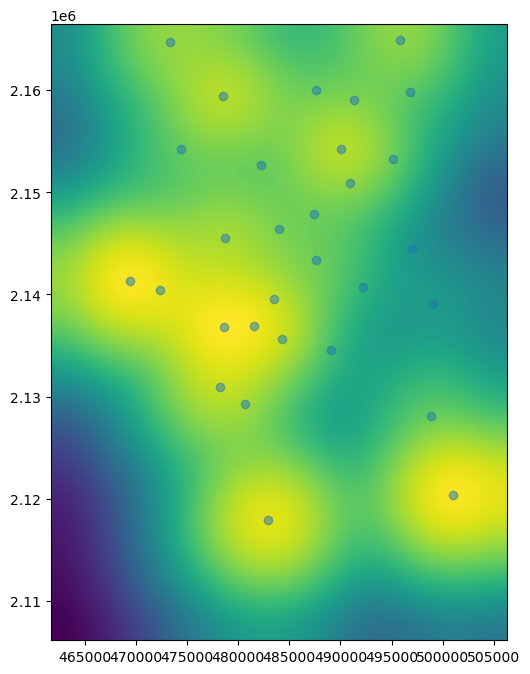

In [ ]:
# Visualiza el resultado
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 8))
plt.imshow(max_filtered, extent=(min_x, max_x, min_y, max_y), origin='lower', cmap='viridis')
plt.scatter(df_day['longitude'], df_day['latitude'], alpha=0.5)
plt.show()

In [ ]:
import plotly.graph_objects as go

# Create the figure
fig = go.Figure()

# Add the CDMX polygons
for _, row in cdmx.iterrows():
    x, y = row.geometry.geoms[0].exterior.xy
    fig.add_trace(go.Scatter(
        x=x.tolist(), 
        y=y.tolist(), 
        mode='lines', 
        line=dict(color='rgba(0,0,0,0.2)'),
        fill='toself',
        fillcolor='rgba(255, 255, 255, 0.1)',
        name='CDMX'
    ))



fig.add_trace(go.Scatter(
    x=df_day['longitude'], 
    y=df_day['latitude'], 
    mode='markers+text',
    marker=dict(
        size=10,
        color=df_day['value'].apply(lambda v: v if not np.isnan(v) else 'white'),
        colorscale='Viridis',
        showscale=True,
        colorbar=dict(title="Concentration (ppb)", orientation="h"),
        line=dict(color='black', width=1)  # Add black border to markers
    ),
    text=df_day['station'],
    textposition="top center",
    hoverinfo='text',
    hovertext=df_day['station'] + ": " + df_day['value'].round(2).astype(str),
    name='Stations'
))


# Update layout
fig.update_layout(
    title="CDMX Air Quality Visualization",
    # xaxis_title="Longitude",
    # yaxis_title="Latitude",
    template="plotly_white",
    showlegend=False,
    width=600,
    height=800
)

# # Add the image from the "new" array
# fig.add_trace(go.Heatmap(
#     z=max_filtered,
#     x=x_grid,
#     y=y_grid,
#     colorscale='Viridis',
#     colorbar=dict(title="Weighted KDE"),
#     opacity=0.6
# ))


# Show the plot
fig.show()